In [129]:
import numpy as np
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler 
import torch 

In [99]:
import torch
import torch.nn as nn 

In [89]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline 

In [7]:
diabetes = datasets.load_diabetes()

In [8]:
type(diabetes.data), type(diabetes.target), diabetes.data.shape, diabetes.target.shape

(numpy.ndarray, numpy.ndarray, (442, 10), (442,))

In [29]:
scaler = StandardScaler()
scaler.fit(diabetes.data)
X = scaler.transform(diabetes.data)
X.shape

(442, 10)

In [32]:
y = diabetes.target

In [30]:
n = len(X)
bias = np.ones(n).reshape((n, -1))
X1 = np.concatenate([bias, X], axis=1)
X1.shape  

(442, 11)

### Closed Form 

In [53]:
class ClosedFormLinearRegression():
    
    def __init__(self, d1, reg=1e-5):
        """
        d1: num. of features + 1, where the extra 1 is for the bias term
        reg: regularization
        """
        self.d1 = d1
        self.reg = reg
        self.w = None
        self.called_fit = False
        
    def fit(self, X, y):
        d1 = self.d1            
        proj = np.linalg.inv(np.dot(X.T, X) + self.reg * np.eye(d1))
        Xy = np.dot(X.T, y)
        self.w = np.dot(proj, Xy)
        self.called_fit = True
    
    def predict(self, X):
        assert self.called_fit
        y_pred = X.dot(self.w)
        return y_pred
    
    def compute_loss(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y_pred - y)**2)
        

In [54]:
model1 = ClosedFormLinearRegression(X1.shape[1])

In [55]:
model1.fit(X1, y)

In [96]:
model1.w

array([152.13348072,  -0.47612024, -11.40686609,  24.72654954,
        15.42940348, -37.67985665,  22.67608662,   4.80609574,
         8.42202781,  35.73440939,   3.21667429])

In [57]:
loss = model1.compute_loss(X1, y)
print(f'{loss:.4f}')

2859.6963


### Gradient descent

In [101]:
class GradientDescentLinearRegression():
    def __init__(self, d, reg=1e-5, lr=1e-1):
        self.d = d
        self.w = np.random.random(d)
        self.b = 0
        self.reg = reg
        self.lr = lr
                
    def predict(self, X):
        y_pred = X.dot(self.w) + self.b
        return y_pred
    
    def compute_loss(self, X, y):
        y_pred = self.predict(X)
        loss = np.mean((y_pred - y) ** 2) + self.reg * (np.sum(self.w ** 2) + self.b ** 2)
        loss *= 0.5
        return loss    
    
    def fit(self, X, y, n_iters):
        history = []
        m = len(X)
        for i in range(n_iters):
            y_pred = self.predict(X)
            diff = y_pred - y
            dw = (1./m) * (X.T.dot(diff)) + self.reg * self.w
            db = np.sum((1./m) * diff) + self.reg * self.b 
            self.w -= self.lr * dw
            self.b -= self.lr * db 
            loss = self.compute_loss(X, y)
            history.append(loss)
        return history 


In [102]:
d = X.shape[1]
model2 = GradientDescentLinearRegression(d)
history2 = model2.fit(X, y, n_iters=100)

In [103]:
np.concatenate((np.array([model2.b]) , model2.w))

array([152.12792245,  -0.31330834, -11.25042383,  25.16840258,
        15.32119011,  -4.58315844,  -4.15125427,  -9.33380706,
         5.321083  ,  23.06627082,   3.34807294])

In [127]:
#fig, ax = plt.subplots(1, figsize=(7, 5))
#ax.plot(range(len(history2)), history2)

### Use PyTorch 

In [106]:
class PyTorchLinearRegression(nn.Module):
    def __init__(self, d, loss_func):
        super(PyTorchLinearRegression, self).__init__()
        self.d = d 
        self.loss_func = loss_func
        self.linear = nn.Linear(d, 1)
        
    def predict(self, X):
        y_pred = self.linear(X).squeeze(1)
        
    def compute_loss(self, y_pred, y):
        loss = self.loss_func(y_pred, y)
        return loss
    
    def forward(self, X):
        y_pred = self.linear(X)
        return y_pred
        

In [107]:
n_iters = 100
reg = 1e-5
lr = 1e-1
loss_func = nn.MSELoss(reduction='mean')
model3 = PyTorchLinearRegression(X.shape[1], loss_func)
optimizer = torch.optim.SGD(model3.parameters(), lr=lr, weight_decay=reg)
X_ = torch.tensor(X, dtype=torch.float)
y_ = torch.tensor(y, dtype=torch.float)

In [108]:
history3 = []
for i in range(n_iters):
    y_pred = model3(X_).squeeze(1)
    loss = model3.compute_loss(y_pred, y_)
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    history3.append(loss.detach().item())
    

In [120]:
np.concatenate(
    (model3.linear.bias.detach().numpy(), model3.linear.weight.detach().squeeze().numpy())
)    


array([152.13269  ,  -0.3303334, -11.2502985,  25.108257 ,  15.307167 ,
        -7.075539 ,  -1.8490058,  -8.597703 ,   4.987753 ,  24.204716 ,
         3.3201215], dtype=float32)

In [128]:
#fig, ax = plt.subplots(1, figsize=(7, 5))
#ax.plot(range(len(history3)), history3)

### Compare 

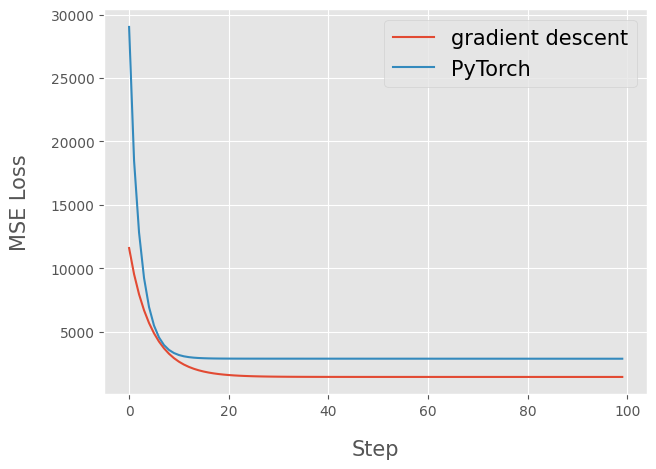

In [126]:
fontsize = 15
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.plot(range(len(history2)), history2, label='gradient descent')
ax.plot(range(len(history3)), history3, label='PyTorch')
ax.set_xlabel('Step', fontsize=fontsize, labelpad=15)
ax.set_ylabel('MSE Loss', fontsize=fontsize, labelpad=15)
ax.legend(loc='best', fontsize=fontsize)